# Instructions for Preparing to Use This Notebook

Before running this notebook:

1. **Install Required Python Packages**  
   This notebook uses several Python packages:
   To install these packages, open a command prompt or terminal and run:
   ```bash
   pip install pandas numpy matplotlib langdetect nltk bertopic umap-learn sentence-transformers

## Block 0: Setup
- Import necessary libraries

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from langdetect import detect, DetectorFactory
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import re
from bertopic import BERTopic
from umap import UMAP
import re
from sentence_transformers import SentenceTransformer


# set seed for reproducible language detection
DetectorFactory.seed = 0
# user inputs
# excel_file_path = "output_topic_modellings_q1.xlsx"   # change to your excel file path
# column_of_interest = "answer" # change to your column name

excel_file_path = "sample.xlsx"   # change to your excel file path
column_of_interest = "BuildNetwork" # change to your column name

## Block 1: Load and Prepare Data
- Load data from an Excel file
- Ensure the column of interest exists
- Drop all other columns except for the column of interest
- Remove rows with missing values in the column of interest

In [302]:
# read excel file and keep only the column of interest
df = pd.read_excel(excel_file_path, usecols=[column_of_interest])

# check if column exists
if column_of_interest not in df.columns:
    raise ValueError(f"column '{column_of_interest}' does not exist. please check the column name.")

# drop rows with missing data in this column
df.dropna(inplace=True)

print(f"data loaded. number of rows after dropping empty rows: {len(df)}")
df.head()

data loaded. number of rows after dropping empty rows: 99


,BuildNetwork
0,go to events arranged for international studen...
1,I attended some courses at Sport Center and ma...
2,projects with random people
4,Talk to people
5,"i came after start of semester, i came for int..."


## Block 2: Basic Preprocessing
- Remove rows where the data is purely numeric or very short
- Visualize the distribution of response lengths

- Reset the index after filtering


removed 0 rows (short or purely numeric).
remaining rows: 99


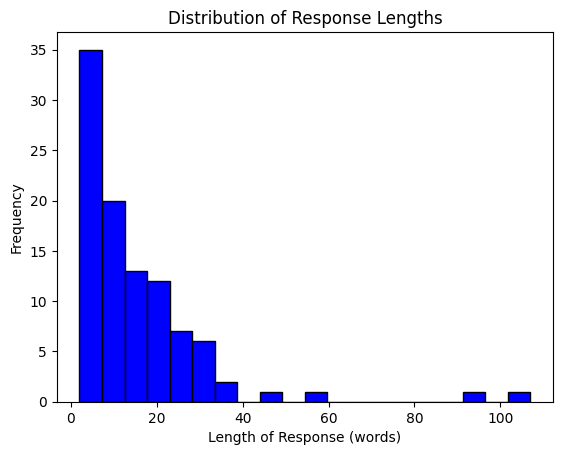

In [303]:
def is_pure_numeric(text):
    """return true if text is purely numeric"""
    return text.isdigit()

def is_short_answer(text, min_length=1):
    """return true if text length is below min_length"""
    return len(text) < min_length

initial_count = len(df)

# filter out purely numeric or short answers
mask_numeric = df[column_of_interest].apply(is_pure_numeric)
mask_short = df[column_of_interest].apply(is_short_answer)
df = df[~mask_numeric & ~mask_short].copy()

# reset index
#df.reset_index(drop=True, inplace=True)

print(f"removed {initial_count - len(df)} rows (short or purely numeric).")
print(f"remaining rows: {len(df)}")

# response lengths and add as a new column
df['response_length'] = df[column_of_interest].str.split().str.len()

# the distribution of response lengths
response_lengths = df['response_length']
plt.hist(response_lengths, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response (words)')
plt.ylabel('Frequency')
plt.show()

## Block 3: Language Detection and Stopwords Setup
- Detect the language of each text entry
- Identify and report the distribution and dominance of languages
- Set stopwords according to the dominant language

In [304]:
# detect language for each entry
df['detected_language'] = df[column_of_interest].apply(lambda text: detect(text) if text.strip() != "" else "unknown")

# count occurrences of each language
lang_counter = Counter(df['detected_language'])
dominant_lang, dominant_count = lang_counter.most_common(1)[0]

# print("Language distribution in your data:")
# for lang, count in lang_counter.items():
#     print(f"{lang}: {count} entries")
# print(f"\nMost dominant language: {dominant_lang} (Count={dominant_count})")

# select stopwords based on the dominant language
if dominant_lang.startswith("en"):
    selected_stopwords = set(stopwords.words("english"))
elif dominant_lang.startswith("nl"):
    selected_stopwords = set(stopwords.words("dutch"))
else:
    #print("Dominant language is neither English nor Dutch (or unknown). Defaulting to English stopwords.")
    selected_stopwords = set(stopwords.words("english"))

## Block 4: Display Frequent Words and Custom Filtering
- Preprocess text to remove punctuation and lowercase all words
- Calculate the frequency of words across all texts
- Display the top 10 most frequent words
- Apply a user-defined list of words for additional filtering

In [305]:
def preprocess_text(text):
    """Lowercase, remove punctuation, and split by whitespace."""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text.split()

# combine and count words in all texts
all_words = [word for text in df[column_of_interest] for word in preprocess_text(text)]
counter_all_words = Counter(all_words)

# user-defined additional filter words
user_filter_words = ["hi", "mom",'none']

print("Custom user-defined words to remove:", user_filter_words)

# merge with existing stopwords
final_stopwords = selected_stopwords.union(set(user_filter_words))

# filter out stopwords from each document
df[column_of_interest] = df[column_of_interest].apply(
    lambda text: " ".join([word for word in preprocess_text(text) if word not in final_stopwords])
)

# word frequencies after filtering
filtered_all_words = [word for text in df[column_of_interest] for word in text.split()]
counter_filtered_words = Counter(filtered_all_words)

# display top_n frequent words after filtering
top_n = 10
print(f"\nTop {top_n} most frequent words:")
for word, count in counter_filtered_words.most_common(top_n):
    print(f"{word}: {count}")

Custom user-defined words to remove: ['hi', 'mom', 'none']

Top 10 most frequent words:
people: 33
intro: 29
week: 24
went: 20
students: 14
joined: 14
activities: 13
events: 12
friends: 11
dutch: 11


## Block 4: Model Selection
- Select an appropriate SentenceTransformer model based on the dominant language.
- Supports specific models for English and a default multilingual model for Dutch or any other language.


In [306]:
def pick_embedding_model(dominant_lang: str):
    """
    selects an appropriate SentenceTransformer model based on language.
    Uses specific models for English or a multilingual model as default.
    """
    # Determine the model based on language
    if dominant_lang.startswith("en"):
        model_name = "all-mpnet-base-v2"
        #model_name = "all-MiniLM-L6-v2"
    elif dominant_lang.startswith("nl"):
        model_name = "paraphrase-multilingual-mpnet-base-v2"
    else:
        model_name = "paraphrase-multilingual-mpnet-base-v2"

    print(f"Using model: {model_name}")
    return SentenceTransformer(model_name)

## Block 5: Conditional Embedding Model
- Select an embedding model based on the dominant language

- Fit the model to generate topic clusters


In [307]:
# model configurations
embedding_model = pick_embedding_model(dominant_lang)  # selects embedding model based on language
min_topic_size = 3  # minimum size for a topic to be considered separated
umap_model1 = UMAP(n_neighbors=10, n_components=3, metric='cosine', random_state=42)

# configure bertopic model
topic_model = BERTopic(embedding_model=embedding_model, min_topic_size=min_topic_size, verbose=True,
                       nr_topics="auto",  # Set 'auto' to let the model decide or specify an integer
                       umap_model= umap_model1)
                       #umap_model=UMAP(random_state=umap_random_state))
                       
# fit the model on the data
documents = df[column_of_interest].tolist()
topics, probabilities = topic_model.fit_transform(documents)
embeddings = topic_model._extract_embeddings(documents)

Using model: all-mpnet-base-v2


2025-02-03 15:21:57,277 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-02-03 15:22:01,995 - BERTopic - Embedding - Completed ✓
2025-02-03 15:22:01,995 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-03 15:22:02,112 - BERTopic - Dimensionality - Completed ✓
2025-02-03 15:22:02,112 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-03 15:22:02,112 - BERTopic - Cluster - Completed ✓
2025-02-03 15:22:02,112 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-03 15:22:02,129 - BERTopic - Representation - Completed ✓
2025-02-03 15:22:02,129 - BERTopic - Topic reduction - Reducing number of topics
2025-02-03 15:22:02,147 - BERTopic - Topic reduction - Reduced number of topics from 12 to 12


## Block 6: Basic Topic Summary and Diagnostics
- Display the topic summary table
- Count how many documents are assigned to the outlier topic (-1)
- Report the number of valid topics


In [308]:
# # generate topic labels with three words, prefixed and separated by a chosen character
# topic_labels = topic_model.generate_topic_labels(nr_words=5, topic_prefix=False , separator='-')

# # assign generated labels to topics in the topic model
# topic_model.topics_ = topic_labels

# get topic summary
topic_info = topic_model.get_topic_info()
print("==== Topic Summary Table ====\n")
print(topic_info.head(15))  # Show the first 15 topics

# count documents in the outlier topic (-1)
outliers = topic_info[topic_info["Topic"] == -1]
outlier_count = outliers["Count"].values[0] if not outliers.empty else 0
print(f"\nOutlier topic (-1) contains {outlier_count} documents.")

# count valid topics
valid_topics = topic_info[topic_info["Topic"] != -1]
print(f"Number of valid topics: {len(valid_topics)}")


==== Topic Summary Table ====

    Topic  Count                               Name  \
0      -1     29        -1_people_friends_one_class   
1       0     11   0_international_sports_many_join   
2       1      9      1_week_intro_participate_akku   
3       2      8           2_dutch_time_speak_never   
4       3      7          3_went_intro_week_student   
5       4      7  4_joined_study_active_association   
6       5      6   5_friends_met_introduction_intro   
7       6      6       6_parties_go_gatherings_dont   
8       7      5    7_students_class_engaging_lunch   
9       8      4  8_talk_pretend_outgoing_naturally   
10      9      4       9_went_horeca_strategy_seems   
11     10      3          10_outside_ub_uni_classes   

                                       Representation  \
0   [people, friends, one, class, much, tried, tal...   
1   [international, sports, many, join, activities...   
2   [week, intro, participate, akku, participating...   
3   [dutch, time, speak, 

## Block 6: Topic Visualization
- Check if the number of valid topics is sufficient for visualization.
- Display a scatter plot of the topic clusters if there are multiple valid topics.
- This visualization helps identify how topics are distributed and whether they form distinct clusters.

**Interpretation and Adjustment:**
- If topics overlap significantly, consider increasing `min_topic_size` or adjusting the UMAP parameters to improve separation.
- If no visualization is shown, ensure that your data contains enough diversity to form multiple topics.


In [309]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(documents, reduced_embeddings=reduced_embeddings)

In [310]:
if len(valid_topics) <= 1:
    print("visualization is not possible or not meaningful.\n")
else: # visualize topics if meaningful
    try:
        fig = topic_model.visualize_topics(width=900, height=800)
        fig.show()
    except ValueError as ve:
        print("\n[ERROR] visualization failed:", ve)

## Block 7: Hierarchical Topic Visualization
- Hierarchical visualizations are useful for understanding the structure of topic groups and finding overarching themes.
- This chart shows the relationship and proximity between different topics, providing insight into how topics are grouped at higher levels.

**Interpretation and Adjustment:**

- If the visualization is unclear or fails, try reducing the number of topics visualized or ensure the model is appropriately fitted with diverse data.

- The **x-axis values** represent the **distance between clusters** in the hierarchical clustering process.
- A **lower value (closer to 0)** means topics are very similar and should likely be merged.
- A **higher value (closer to 1)** means topics are more distinct and might be better kept separate.

- **If topics seem too fragmented:** Increase the `min_topic_size` parameter in BERTopic to force larger groupings.
- **If topics seem too broad:** Reduce `min_topic_size` or use a lower-dimensional embedding model to differentiate topics better.

In [311]:
try:
    fig_hierarchy = topic_model.visualize_hierarchy(
        top_n_topics=30,      # show up to 30 topics
        width=1000, 
        height=600
    )
    fig_hierarchy.show()
except Exception as e:
    print("Could not generate hierarchical topic visualization:", e)
    print("Ensure you have multiple topics and a fitted model.")


## Block 8: Bar Chart of Top Words per Topic
- Display a bar chart showing the most significant words in each topic.
- This visualization provides a quick overview of the content defining each topic.

**Interpretation and Adjustment:**
- This chart is essential for assessing the quality and relevance of each topic based on its top words.
- If topics seem to contain irrelevant or overlapping keywords, consider more specific data preprocessing.


In [312]:
try:
    fig_barchart = topic_model.visualize_barchart(
        top_n_topics=20,   # number of topics to show
        n_words=50,        # top words for each topic
        width=300,
        height=400
    )
    fig_barchart.show()
except Exception as e:
    print("Bar chart visualization error:", e)

## Block 9: Heatmap of Topic Similarities
- Generate and display a heatmap to visualize the similarity between different topics.
- Each cell in the heatmap shows how closely related one topic is to another, which can help identify topics that might be merged or further split.
- A heatmap with many high similarity scores suggests some topics are very closely related and might need refining.


In [313]:
try:
    fig_heatmap = topic_model.visualize_heatmap(
        top_n_topics=100,
        width=900,
        height=600
    )
    fig_heatmap.show()
except Exception as e:
    print("Heatmap visualization error:", e)


## Block 10: Export the file

In [314]:
df["topic"] = topics
df["topic_probability"] = probabilities
df.head(5)

,BuildNetwork,response_length,detected_language,topic,topic_probability
0,go events arranged international students join...,15,en,3,0.884899
1,attended courses sport center made friends,13,en,-1,0.000000
2,projects random people,4,en,-1,0.000000
4,talk people,3,en,8,1.000000
5,came start semester came internship studies di...,22,en,-1,0.000000
